# Poisson

Starting simulations with 200 CPUs...


Running simulations: 100%|██████████| 102000/102000 [01:02<00:00, 1636.30it/s]


Simulation completed in 66.93 seconds


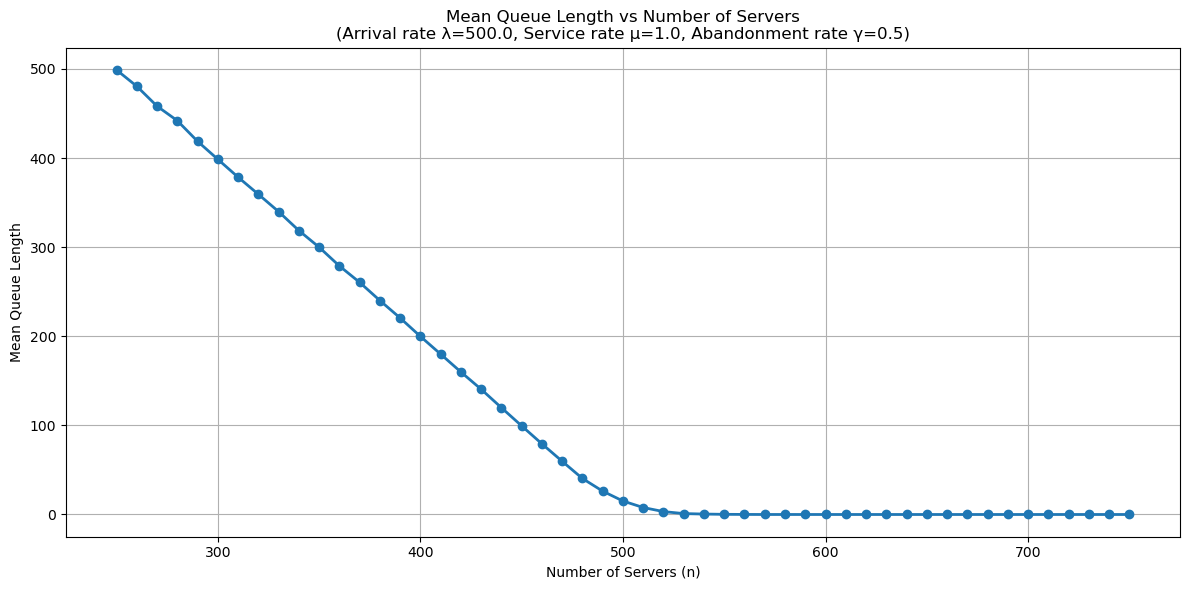

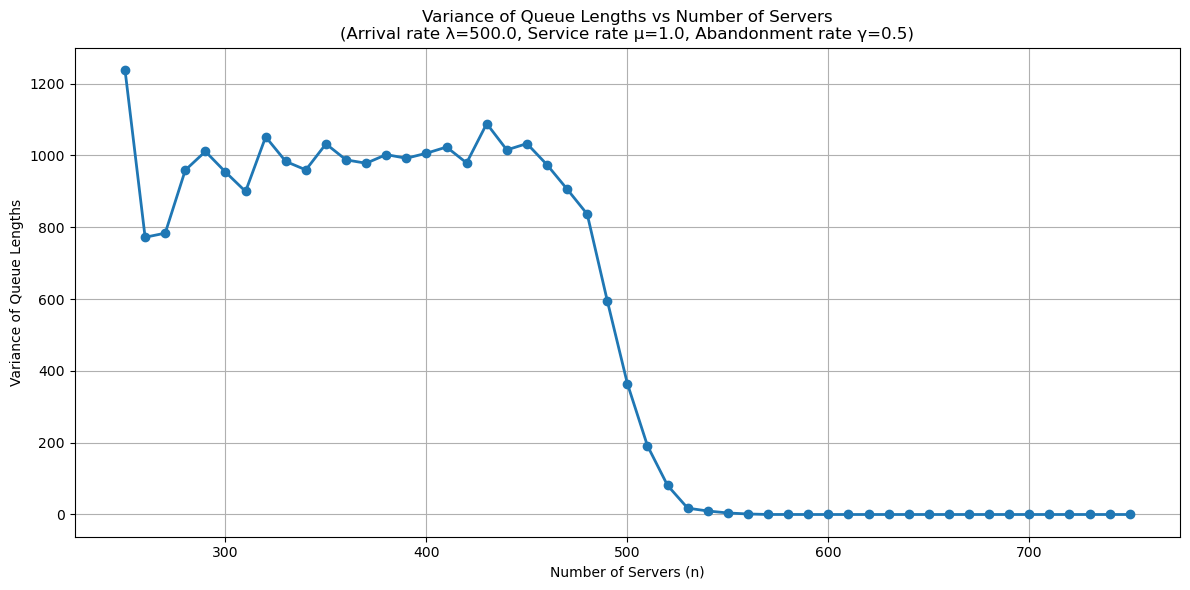

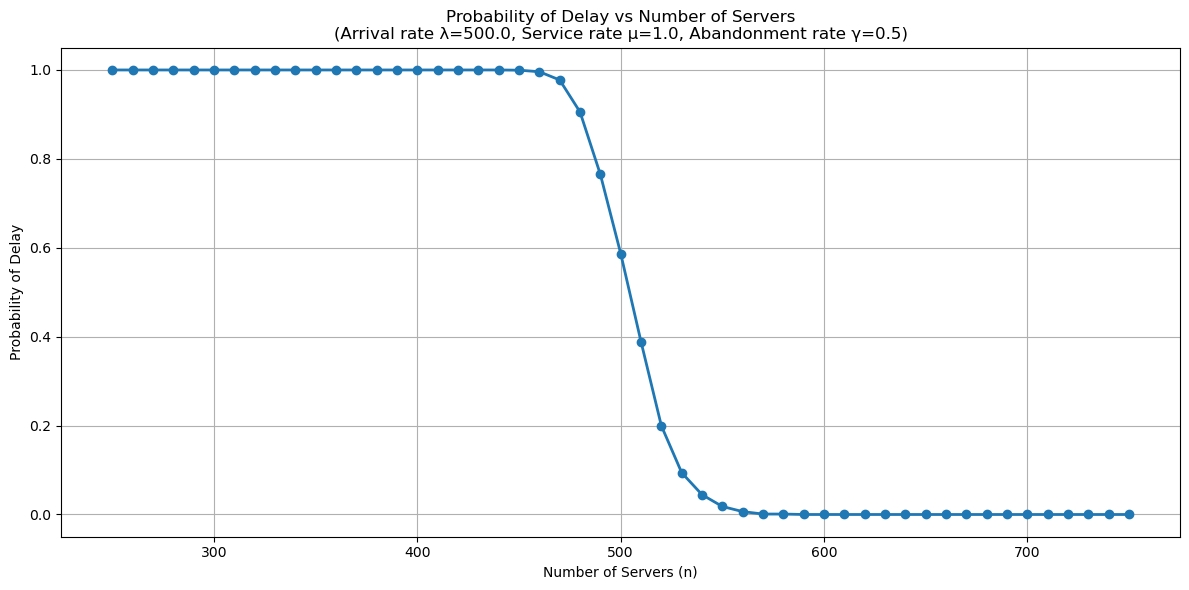

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from math import log
import heapq
from multiprocessing import Pool, cpu_count
import time
import tqdm

class ErlangCSimulation:
    def __init__(self, arrival_rate, service_rate, num_servers, abandonment_rate, sim_time):
        self.arrival_rate = arrival_rate
        self.service_rate = service_rate
        self.num_servers = num_servers
        self.abandonment_rate = abandonment_rate
        self.sim_time = sim_time
        
        # State variables
        self.queue = []
        self.servers_busy = 0
        self.queue_length_history = []
        self.time_history = []
        self.current_time = 0
        self.event_queue = []
        
        # Statistics
        self.total_arrivals = 0
        self.total_served = 0
        self.total_abandoned = 0
    
    def exponential(self, rate):
        """Generate exponential random variate."""
        return -log(1 - np.random.random()) / rate
    
    def schedule_event(self, event_time, event_type, customer_id=None):
        heapq.heappush(self.event_queue, (event_time, event_type, customer_id))
    
    def run_simulation(self):
        # Schedule first arrival
        first_arrival = self.exponential(self.arrival_rate)
        self.schedule_event(first_arrival, 'arrival')
        
        self.queue_length_history.append(0)
        self.time_history.append(0)
        
        while self.current_time < self.sim_time:
            if not self.event_queue:
                break
                
            event_time, event_type, customer_id = heapq.heappop(self.event_queue)
            self.current_time = event_time
            
            self.queue_length_history.append(len(self.queue))
            self.time_history.append(self.current_time)
            
            if event_type == 'arrival':
                self.process_arrival()
            elif event_type == 'service':
                self.process_service(customer_id)
            elif event_type == 'abandonment':
                self.process_abandonment(customer_id)
        
        self.queue_length_history.append(len(self.queue))
        self.time_history.append(self.current_time)
        
        # Calculate time-weighted average queue length
        # time_intervals = np.diff(self.time_history)
        # queue_lengths = np.array(self.queue_length_history[:-1])
        # avg_queue_length = np.sum(time_intervals * queue_lengths) / self.sim_time

        last_length = self.queue_length_history[-1]

        # calculate the number in system at the end of the simulation
        if self.servers_busy > 0:
            last_length += self.servers_busy
        
        return last_length  # Return the last queue length
    
    def process_arrival(self):
        self.total_arrivals += 1
        
        next_arrival = self.current_time + self.exponential(self.arrival_rate)
        self.schedule_event(next_arrival, 'arrival')
        
        if self.servers_busy < self.num_servers:
            self.servers_busy += 1
            service_time = self.current_time + self.exponential(self.service_rate)
            self.schedule_event(service_time, 'service', self.total_arrivals)
        else:
            self.queue.append(self.total_arrivals)
            abandonment_time = self.current_time + self.exponential(self.abandonment_rate)
            self.schedule_event(abandonment_time, 'abandonment', self.total_arrivals)
    
    def process_service(self, customer_id):
        self.total_served += 1
        self.servers_busy -= 1
        
        if self.queue:
            next_customer = self.queue.pop(0)
            service_time = self.current_time + self.exponential(self.service_rate)
            self.schedule_event(service_time, 'service', next_customer)
            self.servers_busy += 1
    
    def process_abandonment(self, customer_id):
        if customer_id in self.queue:
            self.queue.remove(customer_id)
            self.total_abandoned += 1

def run_single_simulation(params):
    """Wrapper function for parallel execution."""
    arrival_rate, service_rate, num_servers, abandonment_rate, sim_time = params
    sim = ErlangCSimulation(arrival_rate, service_rate, num_servers, abandonment_rate, sim_time)
    return sim.run_simulation()

def main():
    # Simulation parameters
    arrival_rate = 500.0  # lambda
    service_rate = 1.0    # mu
    abandonment_rate = 0.5 # gamma
    sim_time = 50       # simulation time per run
    num_paths = 2000       # number of simulation paths per n
    n_values = np.linspace(250,750,51)  # number of servers to test
    
    # Prepare parameter combinations
    params_list = []
    for n in n_values:
        for _ in range(num_paths):
            params_list.append((arrival_rate, service_rate, n, abandonment_rate, sim_time))
    
    # Run simulations in parallel
    print(f"Starting simulations with 200 CPUs...")
    start_time = time.time()
    
    with Pool(processes=200) as pool:
        # results = pool.map(run_single_simulation, params_list)
        # Using tqdm to show progress
        results = list(tqdm.tqdm(pool.imap(run_single_simulation, params_list), total=len(params_list), desc="Running simulations"))
    
    # Organize results by n value
    length_by_n = {n: [] for n in n_values}
    for i, n in enumerate(np.repeat(list(n_values), num_paths)):
        length_by_n[n].append(max(results[i]-n,0))
    
    # Calculate mean queue length for each n
    mean_queue_lengths = []
    for n in n_values:
        mean_queue_lengths.append(np.mean(length_by_n[n]))

    var_queue_lengths = []
    for n in n_values:
        var_queue_lengths.append(np.var(length_by_n[n]))

    p_delay_list = {n: [] for n in n_values}
    for i, n in enumerate(np.repeat(list(n_values), num_paths)):
        w = 1 if results[i] > n else 0
        p_delay_list[n].append(w)

    p_delay = [np.mean(p_delay_list[n]) for n in n_values]
    
    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(n_values, mean_queue_lengths, 'o-', linewidth=2, markersize=6)
    plt.xlabel('Number of Servers (n)')
    plt.ylabel('Mean Queue Length')
    plt.title(f'Mean Queue Length vs Number of Servers\n(Arrival rate λ={arrival_rate}, Service rate μ={service_rate}, Abandonment rate γ={abandonment_rate})')
    plt.grid(True)
    plt.tight_layout()

    # Plot variance of queue lengths
    plt.figure(figsize=(12, 6))
    plt.plot(n_values, var_queue_lengths, 'o-', linewidth=2, markersize=6)
    plt.xlabel('Number of Servers (n)')
    plt.ylabel('Variance of Queue Lengths')
    plt.title(f'Variance of Queue Lengths vs Number of Servers\n(Arrival rate λ={arrival_rate}, Service rate μ={service_rate}, Abandonment rate γ={abandonment_rate})')
    plt.grid(True)
    plt.tight_layout()

    # plot probability of delay upon n
    plt.figure(figsize=(12, 6))
    plt.plot(n_values, p_delay, 'o-', linewidth=2, markersize=6)
    plt.xlabel('Number of Servers (n)')
    plt.ylabel('Probability of Delay')
    plt.title(f'Probability of Delay vs Number of Servers\n(Arrival rate λ={arrival_rate}, Service rate μ={service_rate}, Abandonment rate γ={abandonment_rate})')
    plt.grid(True)
    plt.tight_layout()
    
    # Save plot
    print(f"Simulation completed in {time.time()-start_time:.2f} seconds")
    
    # Show plot
    plt.show()

    return mean_queue_lengths, var_queue_lengths, p_delay

if __name__ == "__main__":
    mean_queue_lengths_poisson, var_queue_lengths_poisson, p_delay_poisson = main()

Simulating for n = 250.0...


100%|██████████| 1000/1000 [00:00<00:00, 12665.95it/s]


Simulating for n = 260.0...


100%|██████████| 1000/1000 [00:00<00:00, 13650.49it/s]


Simulating for n = 270.0...


100%|██████████| 1000/1000 [00:00<00:00, 14365.04it/s]


Simulating for n = 280.0...


100%|██████████| 1000/1000 [00:00<00:00, 13926.84it/s]


Simulating for n = 290.0...


100%|██████████| 1000/1000 [00:00<00:00, 13994.49it/s]


Simulating for n = 300.0...


100%|██████████| 1000/1000 [00:00<00:00, 14122.43it/s]


Simulating for n = 310.0...


100%|██████████| 1000/1000 [00:00<00:00, 14290.21it/s]


Simulating for n = 320.0...


100%|██████████| 1000/1000 [00:00<00:00, 13950.51it/s]


Simulating for n = 330.0...


100%|██████████| 1000/1000 [00:00<00:00, 12451.40it/s]


Simulating for n = 340.0...


100%|██████████| 1000/1000 [00:00<00:00, 13822.15it/s]


Simulating for n = 350.0...


100%|██████████| 1000/1000 [00:00<00:00, 13177.49it/s]


Simulating for n = 360.0...


100%|██████████| 1000/1000 [00:00<00:00, 12839.30it/s]


Simulating for n = 370.0...


100%|██████████| 1000/1000 [00:00<00:00, 13690.63it/s]


Simulating for n = 380.0...


100%|██████████| 1000/1000 [00:00<00:00, 14304.53it/s]


Simulating for n = 390.0...


100%|██████████| 1000/1000 [00:00<00:00, 13786.21it/s]


Simulating for n = 400.0...


100%|██████████| 1000/1000 [00:00<00:00, 13093.53it/s]


Simulating for n = 410.0...


100%|██████████| 1000/1000 [00:00<00:00, 13019.36it/s]


Simulating for n = 420.0...


100%|██████████| 1000/1000 [00:00<00:00, 13472.99it/s]


Simulating for n = 430.0...


100%|██████████| 1000/1000 [00:00<00:00, 13296.97it/s]


Simulating for n = 440.0...


100%|██████████| 1000/1000 [00:00<00:00, 13289.39it/s]


Simulating for n = 450.0...


100%|██████████| 1000/1000 [00:00<00:00, 13645.56it/s]


Simulating for n = 460.0...


100%|██████████| 1000/1000 [00:00<00:00, 12901.62it/s]


Simulating for n = 470.0...


100%|██████████| 1000/1000 [00:00<00:00, 13446.26it/s]


Simulating for n = 480.0...


100%|██████████| 1000/1000 [00:00<00:00, 13604.31it/s]


Simulating for n = 490.0...


100%|██████████| 1000/1000 [00:00<00:00, 13939.66it/s]


Simulating for n = 500.0...


100%|██████████| 1000/1000 [00:00<00:00, 13207.70it/s]


Simulating for n = 510.0...


100%|██████████| 1000/1000 [00:00<00:00, 12341.12it/s]


Simulating for n = 520.0...


100%|██████████| 1000/1000 [00:00<00:00, 13184.29it/s]


Simulating for n = 530.0...


100%|██████████| 1000/1000 [00:00<00:00, 13439.79it/s]


Simulating for n = 540.0...


100%|██████████| 1000/1000 [00:00<00:00, 13735.78it/s]


Simulating for n = 550.0...


100%|██████████| 1000/1000 [00:00<00:00, 13709.61it/s]


Simulating for n = 560.0...


100%|██████████| 1000/1000 [00:00<00:00, 14325.98it/s]


Simulating for n = 570.0...


100%|██████████| 1000/1000 [00:00<00:00, 13707.19it/s]


Simulating for n = 580.0...


100%|██████████| 1000/1000 [00:00<00:00, 13330.82it/s]


Simulating for n = 590.0...


100%|██████████| 1000/1000 [00:00<00:00, 13917.87it/s]


Simulating for n = 600.0...


100%|██████████| 1000/1000 [00:00<00:00, 13794.51it/s]


Simulating for n = 610.0...


100%|██████████| 1000/1000 [00:00<00:00, 13316.52it/s]


Simulating for n = 620.0...


100%|██████████| 1000/1000 [00:00<00:00, 13707.73it/s]


Simulating for n = 630.0...


100%|██████████| 1000/1000 [00:00<00:00, 13585.14it/s]


Simulating for n = 640.0...


100%|██████████| 1000/1000 [00:00<00:00, 12847.36it/s]


Simulating for n = 650.0...


100%|██████████| 1000/1000 [00:00<00:00, 13295.62it/s]


Simulating for n = 660.0...


100%|██████████| 1000/1000 [00:00<00:00, 13206.66it/s]


Simulating for n = 670.0...


100%|██████████| 1000/1000 [00:00<00:00, 13894.08it/s]


Simulating for n = 680.0...


100%|██████████| 1000/1000 [00:00<00:00, 12964.23it/s]


Simulating for n = 690.0...


100%|██████████| 1000/1000 [00:00<00:00, 13214.28it/s]


Simulating for n = 700.0...


100%|██████████| 1000/1000 [00:00<00:00, 13157.16it/s]


Simulating for n = 710.0...


100%|██████████| 1000/1000 [00:00<00:00, 13187.69it/s]


Simulating for n = 720.0...


100%|██████████| 1000/1000 [00:00<00:00, 12801.17it/s]


Simulating for n = 730.0...


100%|██████████| 1000/1000 [00:00<00:00, 14288.36it/s]


Simulating for n = 740.0...


100%|██████████| 1000/1000 [00:00<00:00, 12904.56it/s]


Simulating for n = 750.0...


100%|██████████| 1000/1000 [00:00<00:00, 13956.31it/s]


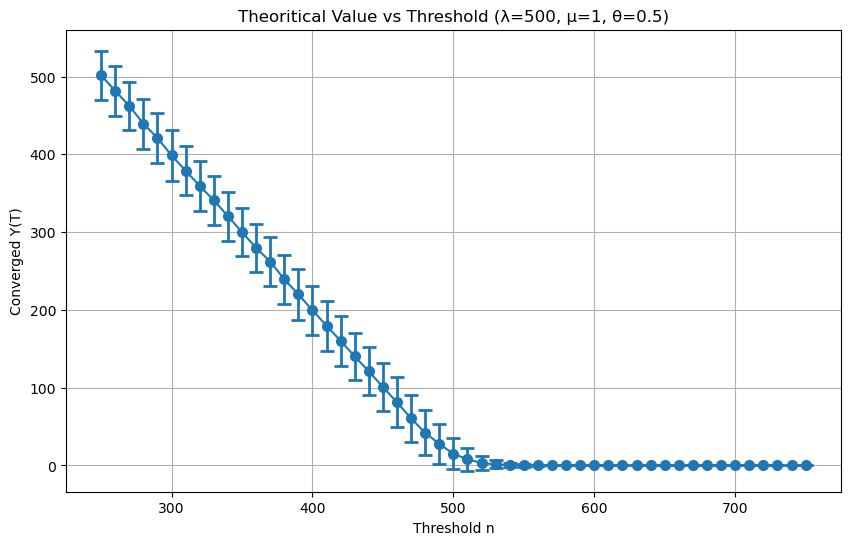

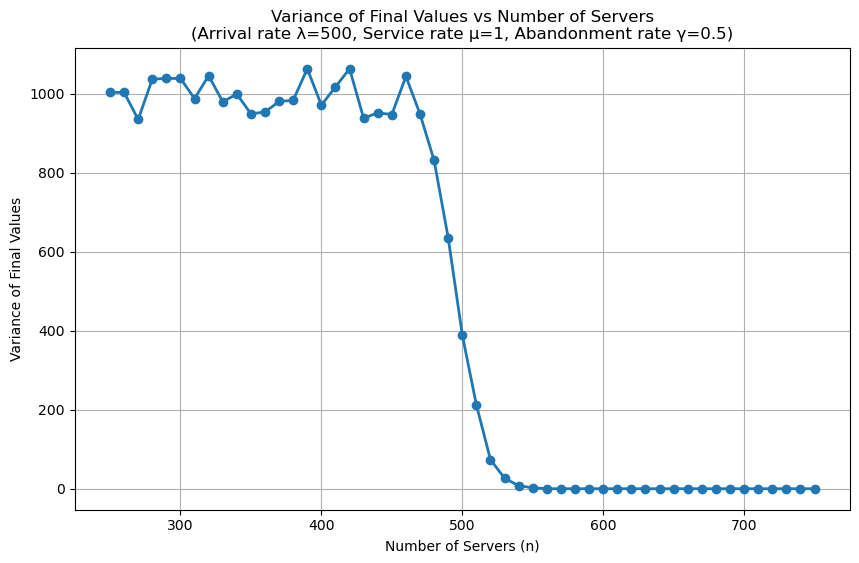

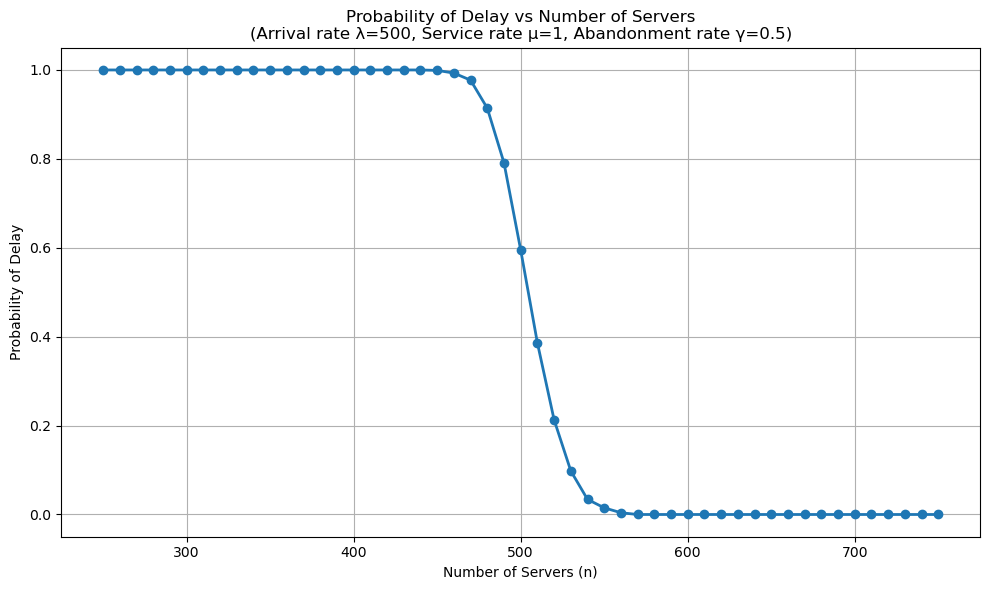

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count
from functools import partial
from tqdm import tqdm

def simulate_single_path(args, Y0, lambda_, mu, theta, n, T, dt):
    """Simulate a single path of the SDE"""
    seed, _ = args
    np.random.seed(seed)
    
    num_steps = int(T / dt)
    Y = Y0
    
    def b(x):
        return lambda_ - mu * np.minimum(x, n) - theta * np.maximum(x - n, 0)
    
    sqrt_2lambda = np.sqrt(2 * lambda_)
    dW = np.random.normal(0, np.sqrt(dt), size=num_steps)
    
    for i in range(num_steps):
        Y = Y + b(Y) * dt + sqrt_2lambda * dW[i]
    
    return Y  # Return just the final value

def parallel_simulation(Y0, lambda_, mu, theta, n, T, dt, num_paths=1000, num_cpus=200):
    """Parallel simulation returning mean final value"""
    seeds = np.random.randint(0, 2**32 - 1, size=num_paths)
    args = list(zip(seeds, range(num_paths)))
    
    sim_func = partial(simulate_single_path,
                     Y0=Y0, lambda_=lambda_, mu=mu, theta=theta,
                     n=n, T=T, dt=dt)
    
    with Pool(processes=min(num_cpus, cpu_count())) as pool:
        results = list(tqdm(pool.imap(sim_func, args), total=num_paths))
    
    final_values = np.array(results)
    return final_values

# Parameters
Y0 = 0.0
lambda_ = 500
mu = 1
theta = 0.5
n_values = np.linspace(250,750,51)  
T = 20.0  # Make sure T is large enough for convergence
dt = 0.01
num_paths = 1000
num_cpus = 200

# Storage for results
theo_means_poisson = []
theo_std_poisson = []
# Storage for variance of final values
theo_vars_poisson = []
# Storage for probability of delay
theo_p_delay_poisson = []

# Run simulations for each n value
for n in n_values:
    print(f"Simulating for n = {n}...")
    final_values = parallel_simulation(Y0, lambda_, mu, theta, n, T, dt, num_paths, num_cpus)

    # take max(0, final_values - n) to ensure non-negative values
    values = np.maximum(final_values - n, 0)
    theo_means_poisson.append(np.mean(values))
    theo_std_poisson.append(np.std(values))
    # Calculate variance of final values
    theo_vars_poisson.append(np.var(values))

    # probability of delay
    p_delay_list = [1 if v > n else 0 for v in final_values]
    theo_p_delay_poisson.append(np.mean(p_delay_list))

# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(n_values, theo_means_poisson, yerr=theo_std_poisson, fmt='-o', 
            capsize=5, elinewidth=2, markeredgewidth=2)
plt.xlabel('Threshold n')
plt.ylabel('Converged Y(T)')
plt.title(f'Theoritical Value vs Threshold (λ={lambda_}, μ={mu}, θ={theta})')
plt.grid(True)

# plot variance of final values
plt.figure(figsize=(10, 6))
plt.plot(n_values, theo_vars_poisson, 'o-', linewidth=2, markersize=6)
plt.xlabel('Number of Servers (n)')
plt.ylabel('Variance of Final Values')
plt.title(f'Variance of Final Values vs Number of Servers\n(Arrival rate λ={lambda_}, Service rate μ={mu}, Abandonment rate γ={theta})')
plt.grid(True)

# Plot probability of delay
plt.figure(figsize=(10, 6))
plt.plot(n_values, theo_p_delay_poisson, 'o-', linewidth=2, markersize=6)
plt.xlabel('Number of Servers (n)')
plt.ylabel('Probability of Delay')
plt.title(f'Probability of Delay vs Number of Servers\n(Arrival rate λ={lambda_}, Service rate μ={mu}, Abandonment rate γ={theta})')
plt.grid(True)
plt.tight_layout()

plt.show()

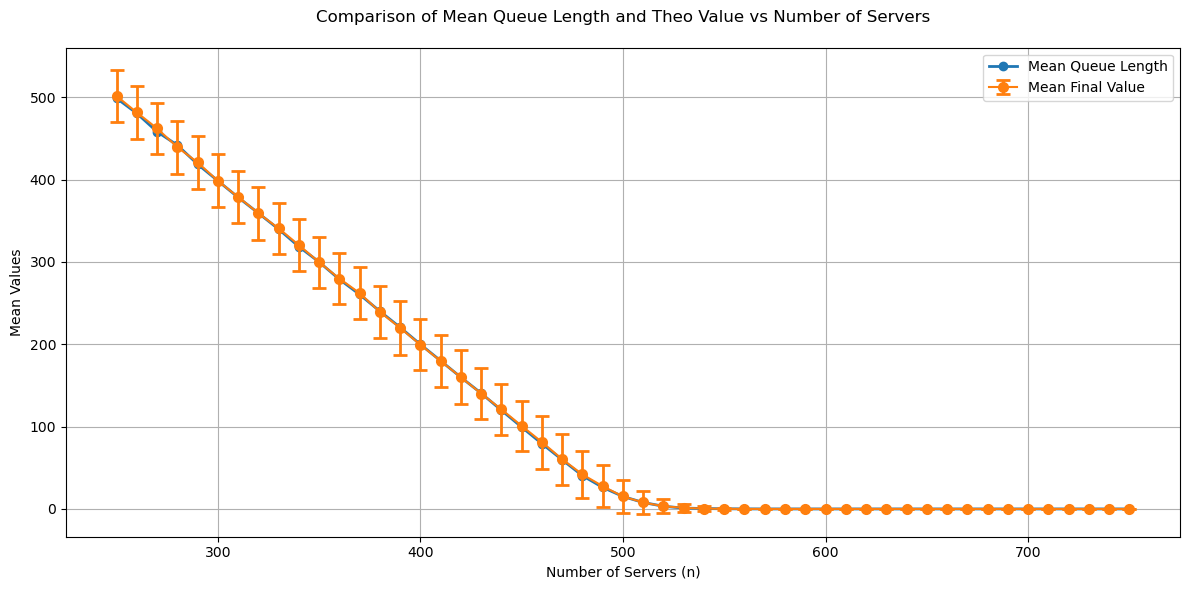

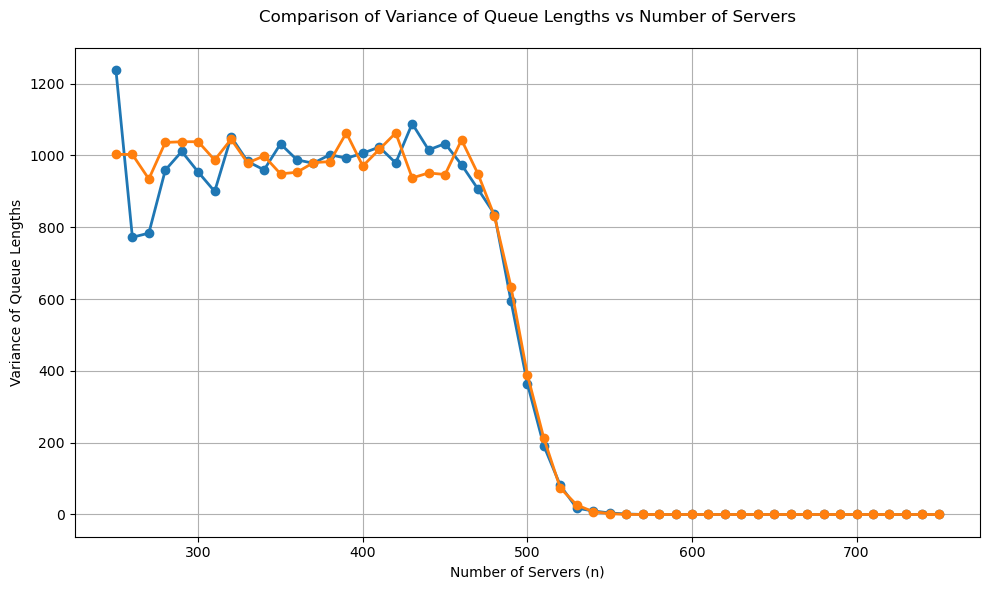

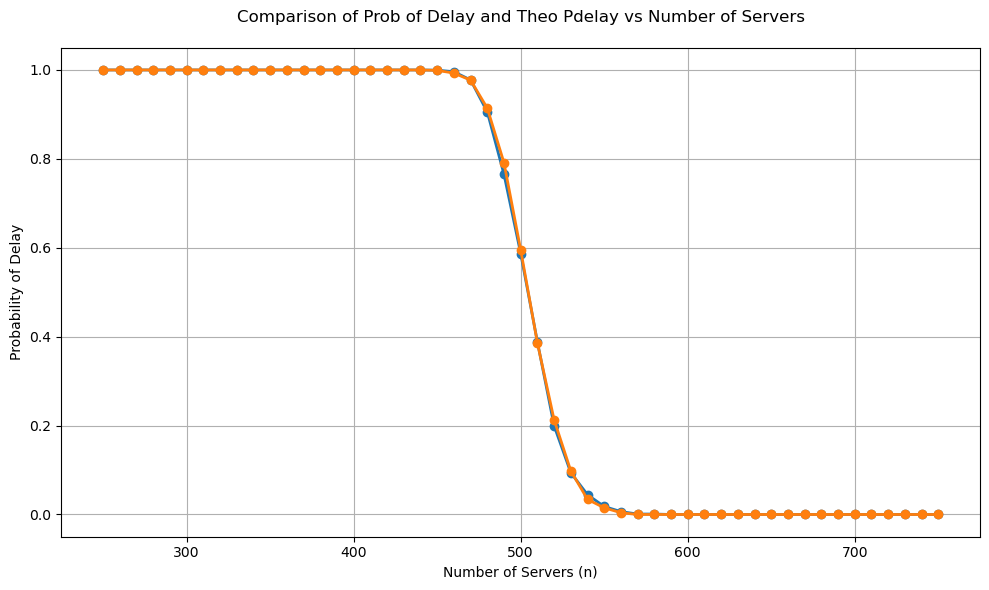

In [9]:
# plot mean_queue_lengths and theo_means upon n_values in one figure
plt.figure(figsize=(12, 6))
plt.plot(n_values, mean_queue_lengths_poisson, 'o-', label='Mean Queue Length', linewidth=2, markersize=6)
plt.errorbar(n_values, theo_means_poisson, yerr=theo_std_poisson, fmt='-o', 
             label='Mean Final Value', capsize=5, elinewidth=2, markeredgewidth=2)
plt.xlabel('Number of Servers (n)')
plt.ylabel('Mean Values')
plt.title('Comparison of Mean Queue Length and Theo Value vs Number of Servers\n')
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.figure(figsize=(10, 6))
plt.plot(n_values, var_queue_lengths_poisson , 'o-', linewidth=2, markersize=6)
plt.plot(n_values, theo_vars_poisson, 'o-', linewidth=2, markersize=6)
plt.xlabel('Number of Servers (n)')
plt.ylabel('Variance of Queue Lengths')
plt.title('Comparison of Variance of Queue Lengths vs Number of Servers\n')
plt.grid(True)
plt.tight_layout()

# plot p_delay and theo_p_delay in one figure
plt.figure(figsize=(10, 6))
plt.plot(n_values, p_delay_poisson, 'o-', linewidth=2, markersize=6)
plt.plot(n_values, theo_p_delay_poisson, 'o-', linewidth=2, markersize=6)
plt.xlabel('Number of Servers (n)')
plt.ylabel('Probability of Delay')
plt.title('Comparison of Prob of Delay and Theo Pdelay vs Number of Servers\n')
plt.grid(True)
plt.tight_layout()

plt.show()

# DSPP

Starting simulations with 200 CPUs...


Running simulations: 100%|██████████| 510000/510000 [07:14<00:00, 1173.83it/s]


Simulation completed in 445.46 seconds


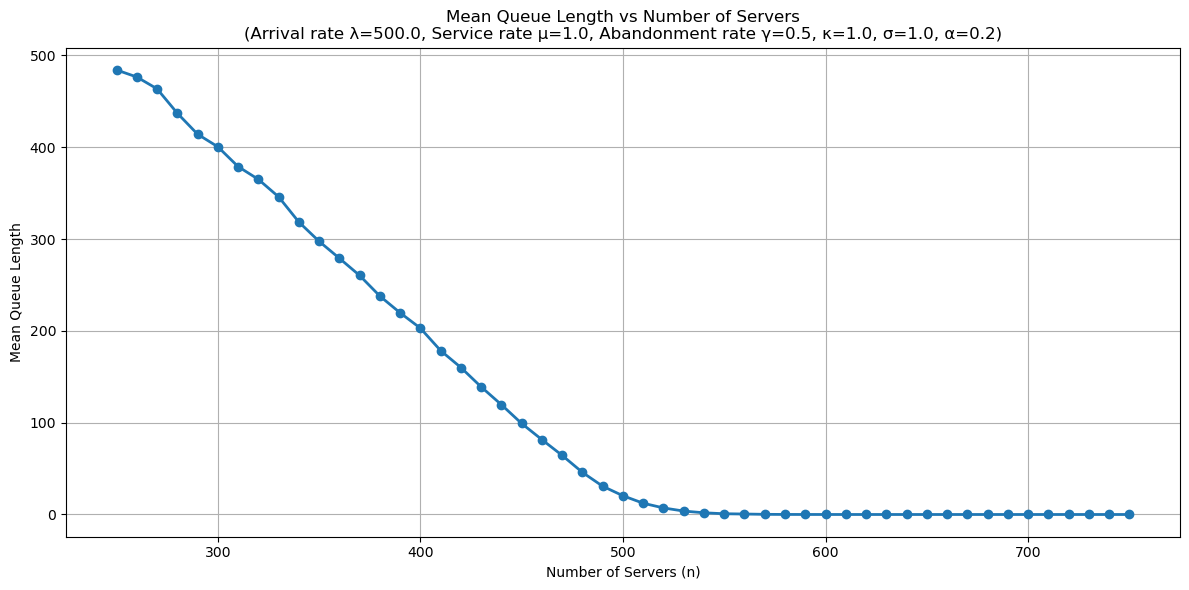

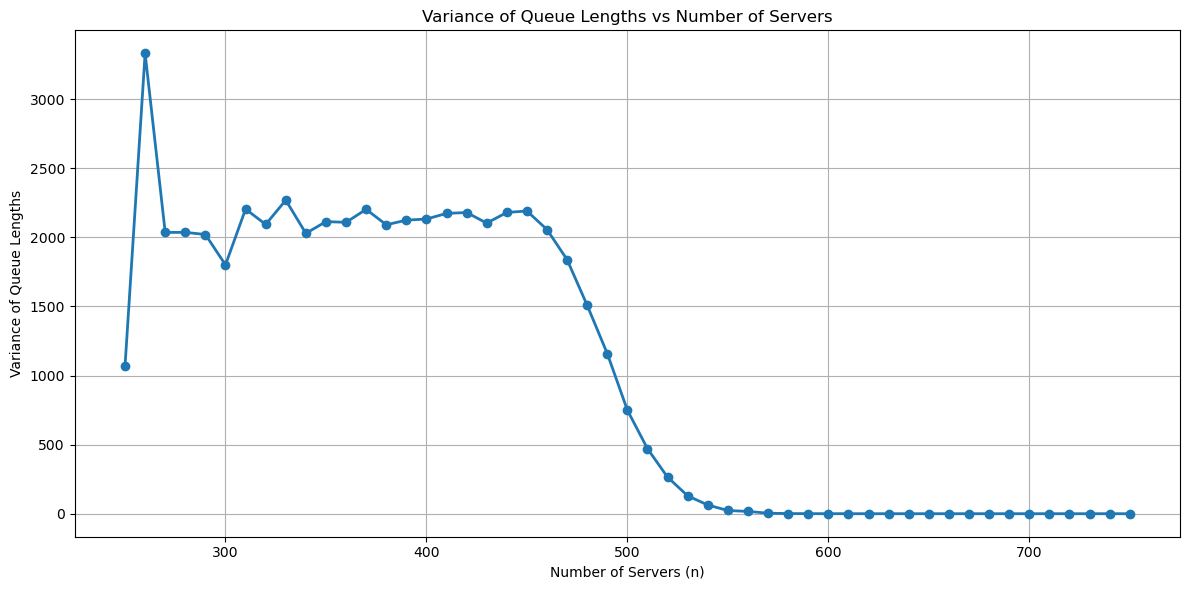

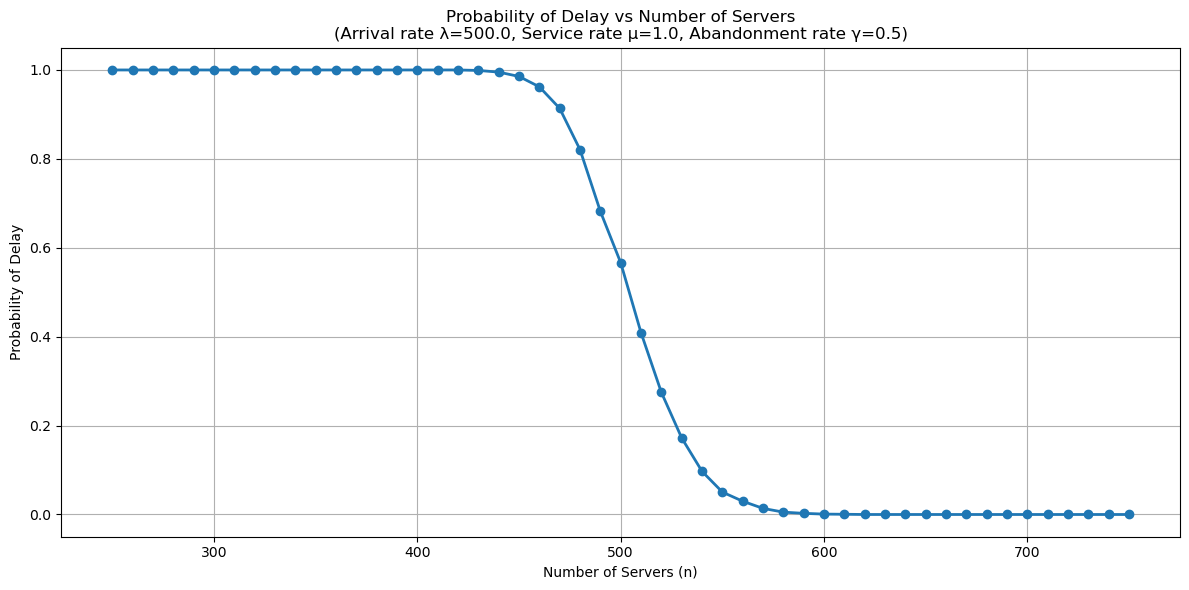

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from math import log
import heapq
from multiprocessing import Pool, cpu_count
import time
import tqdm

class ErlangCSimulation:
    def __init__(self, arrival_rate, service_rate, num_servers, abandonment_rate, sim_time, kappa=1.0, sigma=0.5, alpha=0.5):
        self.arrival_rate = arrival_rate  # lambda
        self.service_rate = service_rate  # mu
        self.num_servers = num_servers
        self.abandonment_rate = abandonment_rate  # gamma
        self.sim_time = sim_time
        self.kappa = kappa
        self.sigma = sigma
        self.alpha = alpha
        
        # State variables
        self.queue = []
        self.servers_busy = 0
        self.queue_length_history = []
        self.time_history = []
        self.current_time = 0
        self.event_queue = []
        
        # Statistics
        self.total_arrivals = 0
        self.total_served = 0
        self.total_abandoned = 0
        
        # DSPP setup
        self.dt = 0.01  # Time step for SDE
        self.time_steps = np.arange(0, self.sim_time + self.dt, self.dt)
        self.rate_trajectory = self.simulate_rate_trajectory()
        self.lambda_max = 2 * self.arrival_rate  # Upper bound for thinning

    def simulate_rate_trajectory(self):
        """Simulate X(t) using Euler-Maruyama method for the SDE."""
        X = np.zeros(len(self.time_steps))
        X[0] = self.arrival_rate  # Initial rate
        for i in range(1, len(self.time_steps)):
            X_prev = X[i-1]
            drift = self.kappa * (self.arrival_rate - X_prev) * self.dt
            diffusion = self.sigma * np.sqrt(self.arrival_rate ** self.alpha * X_prev) * np.sqrt(self.dt) * np.random.normal()
            X[i] = max(X_prev + drift + diffusion, 0)  # Ensure non-negative
        return X

    def get_rate_at_time(self, t):
        """Interpolate X(t) at time t."""
        idx = int(t / self.dt)
        if idx >= len(self.rate_trajectory) - 1:
            return self.rate_trajectory[-1]
        frac = (t - idx * self.dt) / self.dt
        return self.rate_trajectory[idx] * (1 - frac) + self.rate_trajectory[idx + 1] * frac

    def generate_next_arrival(self):
        """Generate next arrival time using thinning for non-homogeneous Poisson process."""
        t = self.current_time
        while True:
            t += -log(1 - np.random.random()) / self.lambda_max
            if t > self.sim_time:
                return self.sim_time + 1  # No more arrivals
            rate = self.get_rate_at_time(t)
            if np.random.random() < rate / self.lambda_max:
                return t
        return self.sim_time + 1

    def exponential(self, rate):
        """Generate exponential random variate."""
        return -log(1 - np.random.random()) / rate

    def schedule_event(self, event_time, event_type, customer_id=None):
        heapq.heappush(self.event_queue, (event_time, event_type, customer_id))

    def run_simulation(self):
        # Schedule first arrival
        first_arrival = self.generate_next_arrival()
        self.schedule_event(first_arrival, 'arrival')
        
        self.queue_length_history.append(0)
        self.time_history.append(0)
        
        while self.current_time < self.sim_time:
            if not self.event_queue:
                break
                
            event_time, event_type, customer_id = heapq.heappop(self.event_queue)
            self.current_time = event_time
            
            self.queue_length_history.append(len(self.queue))
            self.time_history.append(self.current_time)
            
            if event_type == 'arrival':
                self.process_arrival()
            elif event_type == 'service':
                self.process_service(customer_id)
            elif event_type == 'abandonment':
                self.process_abandonment(customer_id)
        
        self.queue_length_history.append(len(self.queue))
        self.time_history.append(self.current_time)
        
        # # Calculate time-weighted average queue length
        # time_intervals = np.diff(self.time_history)
        # queue_lengths = np.array(self.queue_length_history[:-1])
        # avg_queue_length = np.sum(time_intervals * queue_lengths) / self.sim_time

        last_length = self.queue_length_history[-1]

        # calculate the number in system at the end of the simulation
        if self.servers_busy > 0:
            last_length += self.servers_busy
        
        return last_length  # Return the last queue length

    def process_arrival(self):
        self.total_arrivals += 1
        
        # Schedule next arrival using DSPP
        next_arrival = self.generate_next_arrival()
        self.schedule_event(next_arrival, 'arrival')
        
        if self.servers_busy < self.num_servers:
            self.servers_busy += 1
            service_time = self.current_time + self.exponential(self.service_rate)
            self.schedule_event(service_time, 'service', self.total_arrivals)
        else:
            self.queue.append(self.total_arrivals)
            abandonment_time = self.current_time + self.exponential(self.abandonment_rate)
            self.schedule_event(abandonment_time, 'abandonment', self.total_arrivals)

    def process_service(self, customer_id):
        self.total_served += 1
        self.servers_busy -= 1
        
        if self.queue:
            next_customer = self.queue.pop(0)
            service_time = self.current_time + self.exponential(self.service_rate)
            self.schedule_event(service_time, 'service', next_customer)
            self.servers_busy += 1

    def process_abandonment(self, customer_id):
        if customer_id in self.queue:
            self.queue.remove(customer_id)
            self.total_abandoned += 1

def run_single_simulation(params):
    """Wrapper function for parallel execution."""
    arrival_rate, service_rate, num_servers, abandonment_rate, sim_time, kappa, sigma, alpha = params
    sim = ErlangCSimulation(arrival_rate, service_rate, num_servers, abandonment_rate, sim_time, kappa, sigma, alpha)
    return sim.run_simulation()

def main():
    # Simulation parameters
    arrival_rate = 500.0  # lambda
    service_rate = 1.0    # mu
    abandonment_rate = 0.5 # gamma
    sim_time = 50       # simulation time per run
    num_paths = 10000     # number of simulation paths per n
    n_values = np.linspace(250, 750, 51)  # number of servers to test
    kappa = 1.0
    sigma = 1.0
    alpha = 0.2
    
    # Prepare parameter combinations
    params_list = []
    for n in n_values:
        for _ in range(num_paths):
            params_list.append((arrival_rate, service_rate, n, abandonment_rate, sim_time, kappa, sigma, alpha))
    
    # Run simulations in parallel
    print(f"Starting simulations with 200 CPUs...")
    start_time = time.time()
    
    with Pool(processes=cpu_count()) as pool:
        results = list(tqdm.tqdm(pool.imap(run_single_simulation, params_list), total=len(params_list), desc="Running simulations"))
    
    # Organize results by n value
    length_by_n = {n: [] for n in n_values}
    for i, n in enumerate(np.repeat(list(n_values), num_paths)):
        length_by_n[n].append(max(results[i]-n,0))
    
    # Calculate mean queue length for each n
    mean_queue_lengths_dspp = []
    var_queue_lengths_dspp = []
    for n in n_values:
        mean_queue_lengths_dspp.append(np.mean(length_by_n[n]))
        var_queue_lengths_dspp.append(np.var(length_by_n[n]))

    p_delay_list = {n: [] for n in n_values}
    for i, n in enumerate(np.repeat(list(n_values), num_paths)):
        w = 1 if results[i] > n else 0
        p_delay_list[n].append(w)

    p_delay_dspp = [np.mean(p_delay_list[n]) for n in n_values]
    
    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(n_values, mean_queue_lengths_dspp, 'o-', linewidth=2, markersize=6)
    plt.xlabel('Number of Servers (n)')
    plt.ylabel('Mean Queue Length')
    plt.title(f'Mean Queue Length vs Number of Servers\n(Arrival rate λ={arrival_rate}, Service rate μ={service_rate}, Abandonment rate γ={abandonment_rate}, κ={kappa}, σ={sigma}, α={alpha})')
    plt.grid(True)
    plt.tight_layout()

    plt.figure(figsize=(12, 6))
    plt.plot(n_values, var_queue_lengths_dspp, 'o-', linewidth=2, markersize=6)
    plt.xlabel('Number of Servers (n)')
    plt.ylabel('Variance of Queue Lengths')
    plt.title(f'Variance of Queue Lengths vs Number of Servers')
    plt.grid(True)
    plt.tight_layout()

    # plot probability of delay upon n
    plt.figure(figsize=(12, 6))
    plt.plot(n_values, p_delay_dspp, 'o-', linewidth=2, markersize=6)
    plt.xlabel('Number of Servers (n)')
    plt.ylabel('Probability of Delay')
    plt.title(f'Probability of Delay vs Number of Servers\n(Arrival rate λ={arrival_rate}, Service rate μ={service_rate}, Abandonment rate γ={abandonment_rate})')
    plt.grid(True)
    plt.tight_layout()
    
    print(f"Simulation completed in {time.time()-start_time:.2f} seconds")
    plt.show()

    return mean_queue_lengths_dspp, var_queue_lengths_dspp, p_delay_dspp

if __name__ == "__main__":
    mean_queue_lengths_dspp, var_queue_lengths_dspp, p_delay_dspp = main()

Processing n values: 100%|██████████| 51/51 [04:37<00:00,  5.45s/it]


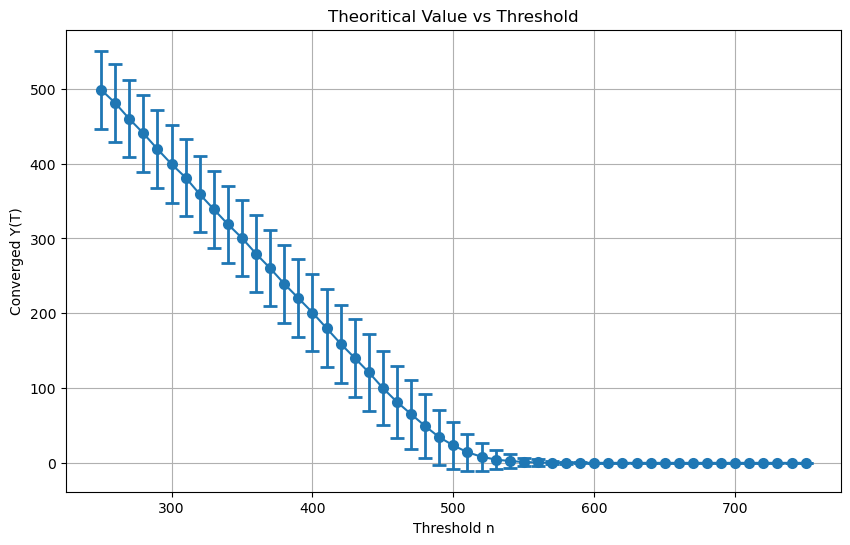

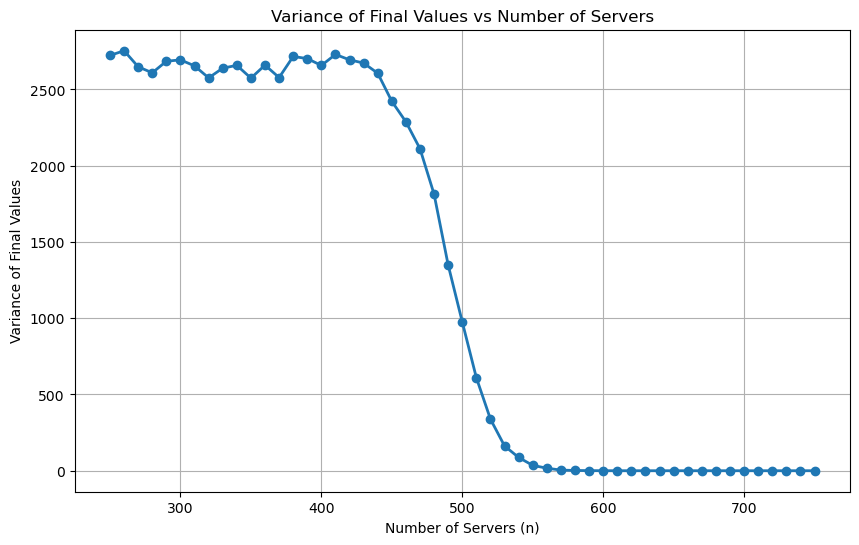

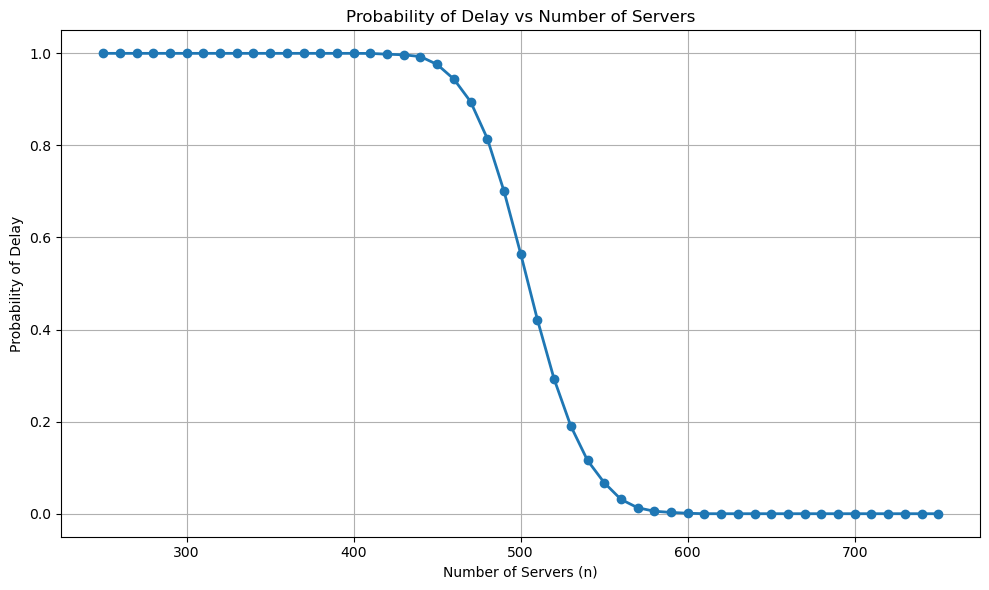

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count
from functools import partial
from tqdm import tqdm  # for progress bar

def simulate_single_path(args, params):
    """Simulate a single path of Y and U."""
    seed, _ = args
    np.random.seed(seed)
    
    Y0 = params['Y0']
    lambda_ = params['lambda_']
    alpha = params['alpha']
    mu = params['mu']
    theta = params['theta']
    n = params['n']
    T = params['T']
    dt = params['dt']
    U0 = params['U0']
    kappa = params['kappa']
    phi = params['phi']
    sigma = params['sigma']
    
    num_steps = int(T / dt)
    t = np.linspace(0, T, num_steps + 1)
    Y = np.zeros(num_steps + 1)
    U = np.zeros(num_steps + 1)
    Y[0] = Y0
    U[0] = U0
    
    def b(x):
        return lambda_ - mu * np.minimum(x, n) - theta * np.maximum(x - n, 0)
    
    sqrt_2lambda = (2 * lambda_) ** ((alpha + 1) / 2)  # Corrected to include factor of 2
    dW_u = np.random.normal(0, np.sqrt(dt), size=num_steps)
    
    for i in range(num_steps):
        U[i + 1] = U[i] + kappa * (phi - U[i]) * dt + sigma * dW_u[i]
        Y[i + 1] = Y[i] + b(Y[i]) * dt + sqrt_2lambda * U[i] * dt
        Y[i + 1] = max(Y[i + 1], 0)  # Apply transformation at each step
    
    return t, Y, U

def parallel_simulation(Y0, lambda_, alpha, mu, theta, n, T, dt, U0, kappa, phi, sigma, num_paths=1000, num_cpus=20):
    """Run parallel simulations and return mean and std of final Y values."""
    seeds = np.random.randint(0, 2**32 - 1, size=num_paths)
    args = list(zip(seeds, range(num_paths)))
    
    sim_func = partial(simulate_single_path, params={
        'Y0': Y0, 'lambda_': lambda_, 'alpha': alpha, 'mu': mu, 'theta': theta,
        'n': n, 'T': T, 'dt': dt, 'U0': U0, 'kappa': kappa, 'phi': phi, 'sigma': sigma
    })
    
    with Pool(processes=min(num_cpus, cpu_count())) as pool:
        results = list(tqdm(pool.imap(sim_func, args), total=num_paths, desc=f"Simulating n={n:.1f}"))
    
    # Extract final Y values from each path
    final_values = np.array([Y[-1] for t, Y, U in results])
    return final_values

def run_simulation_for_n(n_value, params, num_paths=100, num_cpus=20):
    """Run simulation for a specific n value and return converged Y statistics."""
    final_values = parallel_simulation(
        Y0=params['Y0'], lambda_=params['lambda_'], alpha=params['alpha'], 
        mu=params['mu'], theta=params['theta'], n=n_value, T=params['T'], 
        dt=params['dt'], U0=params['U0'], kappa=params['kappa'], 
        phi=params['phi'], sigma=params['sigma'],
        num_paths=num_paths, num_cpus=num_cpus
    )
    
    return final_values

# Parameters
params = {
    'Y0': 0.0,
    'lambda_': 500,
    'alpha': 0.2,
    'mu': 1,
    'theta': 0.5,
    'T': 20.0,
    'dt': 0.01,
    'U0': 0.0,
    'kappa': 1,
    'phi': 0.0,
    'sigma': 1.0
}

# Range of n values to test
n_values = np.linspace(250, 750, 51)  # 300 to 400, 11 points
num_paths = 5000  # Number of paths per simulation
num_cpus = min(200, cpu_count())  # Use up to 20 CPUs or available CPUs

# Store results
theo_means_dspp = []
theo_std_dspp = []
theo_vars_dspp = []
theo_p_delay_dspp = []

# Run simulations for each n
for n in tqdm(n_values, desc="Processing n values"):
    final_values = run_simulation_for_n(n, params, num_paths, num_cpus)
    positive_values = np.maximum(final_values - n, 0)  # Ensure non-negative values
    theo_means_dspp.append(np.mean(positive_values))
    theo_std_dspp.append(np.std(positive_values))
    theo_vars_dspp.append(np.var(positive_values))

    theo_p_delay_dspp.append(np.mean(final_values > n))

# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(n_values, theo_means_dspp, yerr=theo_std_dspp, fmt='-o', 
            capsize=5, elinewidth=2, markeredgewidth=2)
plt.xlabel('Threshold n')
plt.ylabel('Converged Y(T)')
plt.title(f'Theoritical Value vs Threshold')
plt.grid(True)

# Plot variance of final values
plt.figure(figsize=(10, 6))
plt.plot(n_values, theo_vars_dspp, 'o-', linewidth=2, markersize=6)
plt.xlabel('Number of Servers (n)')
plt.ylabel('Variance of Final Values')
plt.title(f'Variance of Final Values vs Number of Servers')
plt.grid(True)

# Plot probability of delay
plt.figure(figsize=(10, 6))
plt.plot(n_values, theo_p_delay_dspp, 'o-', linewidth=2, markersize=6)
plt.xlabel('Number of Servers (n)')
plt.ylabel('Probability of Delay')
plt.title(f'Probability of Delay vs Number of Servers')
plt.grid(True)
plt.tight_layout()

plt.show()

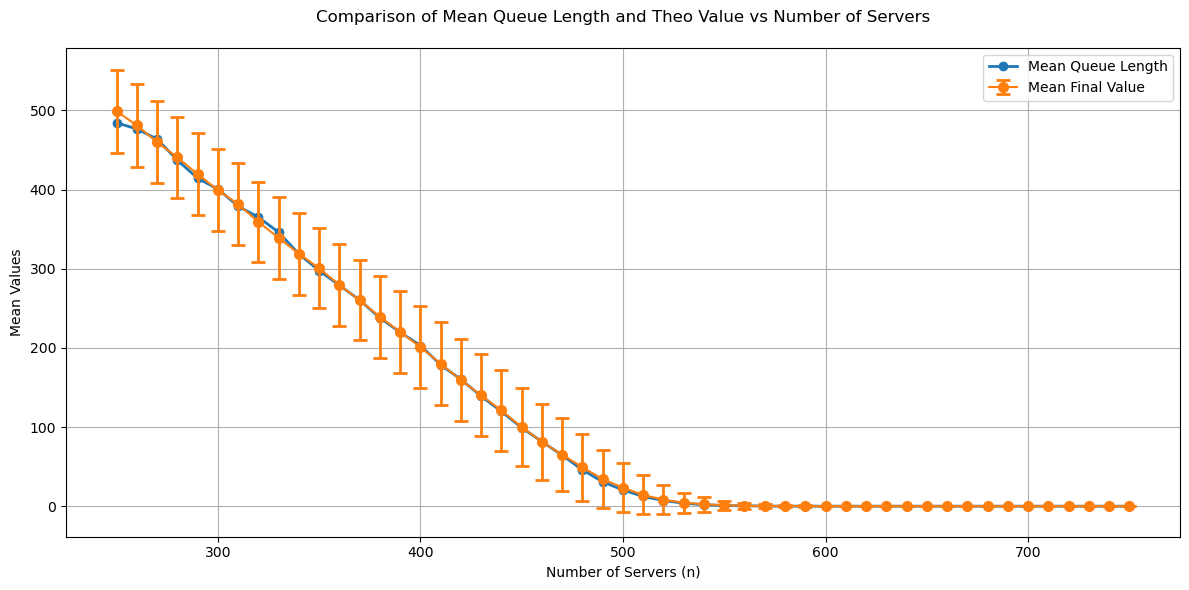

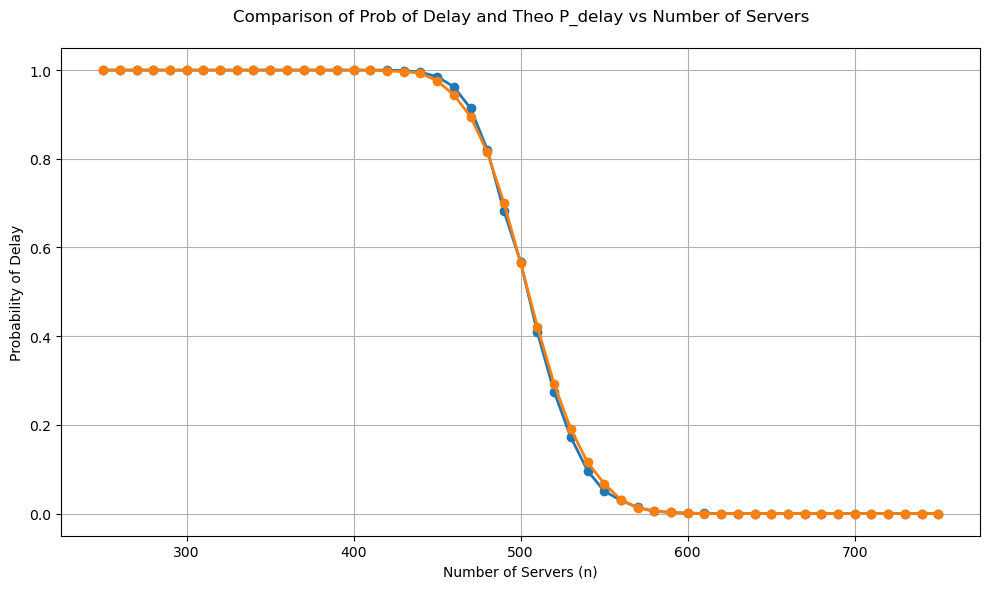

In [12]:
# plot mean_queue_lengths and theo_means upon n_values in one figure
plt.figure(figsize=(12, 6))
plt.plot(n_values, mean_queue_lengths_dspp, 'o-', label='Mean Queue Length', linewidth=2, markersize=6)
plt.errorbar(n_values, theo_means_dspp, yerr=theo_std_dspp, fmt='-o', 
             label='Mean Final Value', capsize=5, elinewidth=2, markeredgewidth=2)
plt.xlabel('Number of Servers (n)')
plt.ylabel('Mean Values')
plt.title('Comparison of Mean Queue Length and Theo Value vs Number of Servers\n')
plt.grid(True)
plt.legend()
plt.tight_layout()

# plot p_delay and theo_p_delay in one figure
plt.figure(figsize=(10, 6))
plt.plot(n_values, p_delay_dspp, 'o-', label = 'p delay queue', linewidth=2, markersize=6)
plt.plot(n_values, theo_p_delay_dspp, 'o-', label = 'p delay theo', linewidth=2, markersize=6)
plt.xlabel('Number of Servers (n)')
plt.ylabel('Probability of Delay')
plt.title('Comparison of Prob of Delay and Theo P_delay vs Number of Servers\n')
plt.grid(True)
plt.tight_layout()

plt.show()

# Test

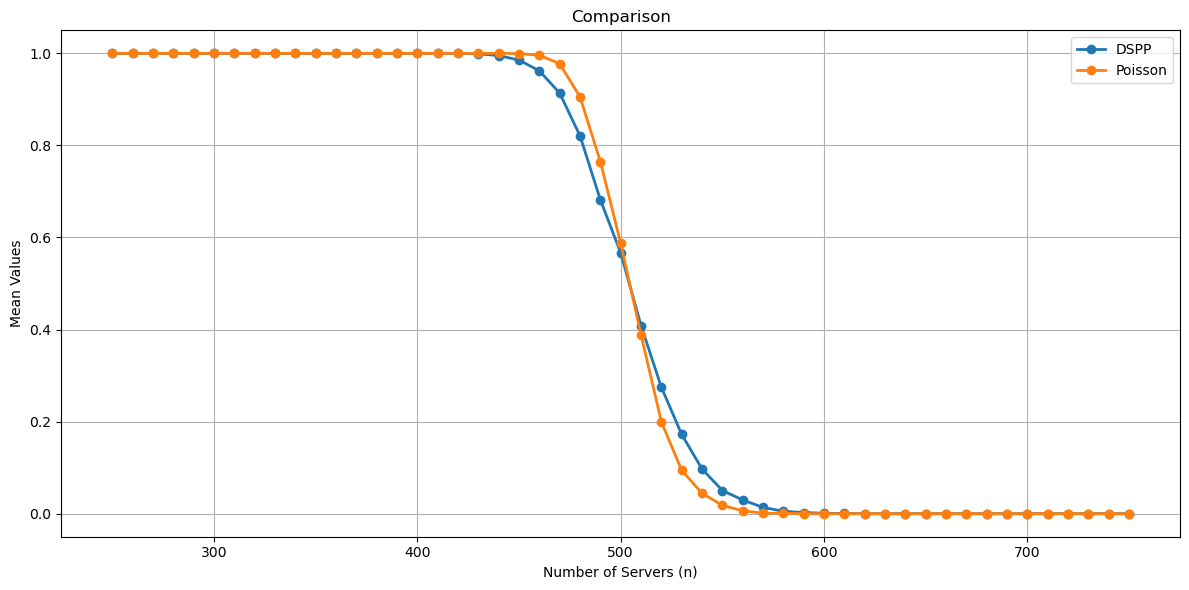

In [16]:
# plot mean_queue_lengths and theo_means upon n_values in one figure
plt.figure(figsize=(12, 6))
plt.plot(n_values, p_delay_dspp, 'o-', label='DSPP', linewidth=2, markersize=6)
plt.plot(n_values, p_delay_poisson, 'o-', label='Poisson', linewidth=2, markersize=6)

plt.xlabel('Number of Servers (n)')
plt.ylabel('Mean Values')
plt.title('Comparison')
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()